In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting
from scipy import io, sparse
import matplotlib.patches as mpatches
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

from src.connectomics.atlases import roidict2hemispheric, get_dk_rois
from src.connectomics.connectivity import calculate_nodal_strength

grp_col = 'temporal_meta_tau_asymmetry_group'
corr_type = 'dk_sc_file'

# comparison
group1_name = 'S'
group2_name = 'RA'
contrast = '[1, -1, 0, 0, 0]'
threshold = '2.5'
permutations = '5000'
mask = 'normal_mask_90' #'no_mask' 'normal_mask_90' 'normal_interhemi_mask_90'

plot_all_components = True
savefig = True

### part 1

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

df_dir = os.path.join(data_dir, 'datasets')
masks_dir = os.path.join(data_dir, 'masks')

df_fname = os.path.join(df_dir, 'bf2_tau_asymmetry_ad_t_xs_tnic_fnc_mri.csv')

nbs_in_dir = os.path.join(data_dir, 'nbs', 'in')
nbs_out_dir = os.path.join(data_dir, 'nbs', 'out')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
connplot_dir = os.path.join(plot_dir, 'nbs')
os.makedirs(connplot_dir, exist_ok=True)

# read dataset
df_ad = pd.read_csv(df_fname, index_col=0, low_memory=False)
df_ad = df_ad[~df_ad[corr_type].isna()]
df_g = df_ad.copy()
    
print(f"Data shape (ad): {df_ad.shape}")

Data shape (ad): (352, 3195)


Found 1 component(s) for S>RA comparison.
26.0
0.0306


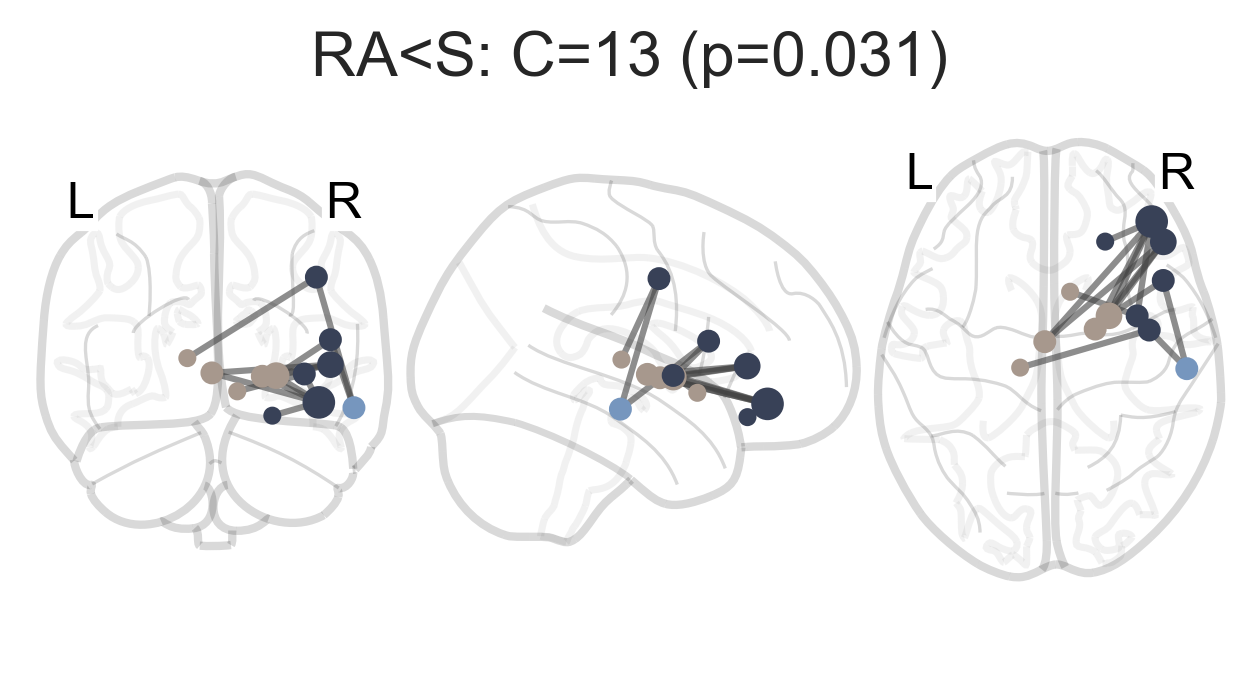

In [2]:
### part 2

# Based on the contrast, define the comparison name
if contrast=='[1, -1, 0, 0, 0]' or contrast=='[1, -1, 0, 0]':
    comparison_name = f'{group1_name}>{group2_name}'
    comparison_name_ = f'{group2_name}<{group1_name}'
elif contrast=='[-1, 1, 0, 0, 0]' or contrast=='[-1, 1, 0, 0]':
    comparison_name = f'{group1_name}<{group2_name}'
    comparison_name_ = f'{group2_name}>{group1_name}'

# defining modifications on loading and processing the connectomes
if corr_type == 'dk_fc_file': 
    drop_first_roi = True # labels in FC matrix to be removed
    fisher = True # apply fisher r-to-z
    replace_nan_with = None
elif corr_type == 'dk_sc_file': 
    drop_first_roi = False
    fisher = False
    replace_nan_with = None
elif corr_type == 'dk_fa_file' or corr_type == 'dk_md_file':
    drop_first_roi = False
    fisher = False
    replace_nan_with = 0

conn_params = dict(drop_first_roi=drop_first_roi, fisher=fisher, 
                   replace_nan_with=replace_nan_with, verbose=True)

# Load the .mat file for NBS results
comparison = f'{group1_name}-{group2_name}_{contrast}'
mat_fname = f'{corr_type}_{mask}_{comparison}_{threshold}_{permutations}.mat'
try:
    mat = io.loadmat(os.path.join(nbs_out_dir, mat_fname))

    # Load the NBS parameters and results from the .mat file
    n_components = mat['n_components'][0, 0]
    node_coords = mat['node_coords']
    node_labels = np.array([label[0][0] for label in mat['node_labels']])
    adj_mats = np.zeros(shape=(node_coords.shape[0], node_coords.shape[0], 1))
    if n_components!=0:
        print(f'Found {n_components} component(s) for {comparison_name} comparison.')
        contrast = mat['contrast'][0]
        threshold = mat['threshold'][0]
        adj_mats_compressed = mat['adj_mat'][0]
        pvals = mat['pval'][0]

        # Get all significant components and their adjacency matrices
        adj_mats = np.zeros(shape=(node_coords.shape[0], node_coords.shape[0], n_components))
        for c in range(n_components):
            # Extract adjacency matrix from the matlab created sparse matrix
            adj_mat_dense = sparse.csc_matrix(adj_mats_compressed[c]).toarray()
            adj_mat_dense_asym = adj_mat_dense + adj_mat_dense.T
            np.fill_diagonal(adj_mat_dense_asym, np.diag(adj_mat_dense))
            adj_mats[:,:,c] = adj_mat_dense_asym

            adj_ndlmask = np.any(adj_mats[:,:,c], axis=0)

            # intra nodal strength of the nodes within the component
            df_g['intra_ndl_strength_nodes'] = df_g[corr_type].apply(
                lambda x: calculate_nodal_strength(x, mask=adj_mats[:,:,c], **conn_params))
            df_g['intra_ndl_strength_avg'] = \
                df_g['intra_ndl_strength_nodes'].apply(np.mean)
            
            # total nodal strength of the nodes within the component
            df_g['total_ndl_strength_nodes'] = df_g[corr_type].apply(
                lambda x: calculate_nodal_strength(x, mask=None, **conn_params))
            df_g['total_ndl_strength_avg'] = df_g['total_ndl_strength_nodes'].apply(
                lambda x: np.mean(x[adj_ndlmask]))
        
        for c in range(adj_mats.shape[-1]):
            print(adj_mats[:,:,c].sum())
            print(pvals[c])
            
    else:
        print(f'No significant NBS components found for {comparison_name} comparison.')
except FileNotFoundError as e:
    print(f'{e}.')

### part 3

adj_mats_m = np.zeros(shape=adj_mats.shape)
if n_components > 1 and plot_all_components:
    adj_mats_m = np.maximum.reduce(adj_mats, axis=-1)
    adj_mats_m = np.expand_dims(adj_mats_m, axis=-1)

### part 4

ROIs = get_dk_rois()
ROIs = {k: v for k, v in ROIs.items() if k in ['cho_com_I_II', 'cho_com_III_IV', 'cho_com_V_VI']}

sns.set_context('talk')
c = 0
dark_bg = False
if dark_bg:
    plt.style.use("dark_background")
else:
    plt.style.use('seaborn-v0_8-white')

# map ROIs to regions
# anatomical_rois_hemi = roidict2hemispheric(anatomical_rois)
anatomical_rois_hemi = roidict2hemispheric(ROIs)
anatomical_rois_hemi2 = {}
for key, regions in anatomical_rois_hemi.items():
    macro_roi = key[:-2]
    if macro_roi not in anatomical_rois_hemi2:
        anatomical_rois_hemi2[macro_roi] = []
    anatomical_rois_hemi2[macro_roi].extend(regions)
reg2roi_map = {region: roi for roi, regions in anatomical_rois_hemi2.items() for region in regions if region in node_labels}
reg2roi_map = {region: reg2roi_map[region] for region in node_labels if region in reg2roi_map}

# define colors for each ROI and therefore to each region
# roi_palette = sns.color_palette("muted", n_colors=len(anatomical_rois_hemi2.keys()))
# roi_colors = {roi: color for roi, color in zip(anatomical_rois_hemi2.keys(), roi_palette)}
roi_colors = {
    # bmsurface @ python-graph-gallery
    'cho_com_I_II': '#D2DCF0FF', #C4E6C3FF
    'cho_com_III_IV': '#7696BEFF', #4DA284FF
    'cho_com_V_VI': '#384157FF' #1D4F60FF
}

# Create node colors list with gray for unassigned regions
# node_colors = [roi_colors[network] for network in reg2roi_map.values()]
node_colors = []
for node in node_labels:
    if node in reg2roi_map:
        node_colors.append(roi_colors[reg2roi_map[node]])
    else:
        node_colors.append('#A7988DFF')

# define plot parameters and node size for each region
connectome_kwargs = dict(edge_kwargs=dict(color='#424242', linewidth=1.5, alpha=0.6),
                         alpha=0.15, node_color=node_colors)
# connectome_kwargs = dict(edge_kwargs=dict(color='#424242', linewidth=1.5, alpha=0.6),
#                          alpha=0.2)
node_size = 0
if n_components != 0:
    nodal_strength = np.nansum(np.abs(adj_mats[:, :, c]), axis=0)
    node_size = nodal_strength / np.max(nodal_strength) * 40
    # c_size = int(adj_mats[:,:,c].sum() / 2)

# plot
fig, axes = plt.subplots(2, 1, figsize=(4, 2), dpi=300)
# fig, axes = plt.subplots(2, 1, figsize=(3, 1.5), dpi=300)
if n_components > 1 and plot_all_components:
    nodal_strength = np.nansum(np.abs(adj_mats_m[:, :, c]), axis=0)
    node_size = nodal_strength / np.max(nodal_strength) * 40
    plotting.plot_connectome(adj_mats_m[:, :, 0], node_coords, black_bg=dark_bg,
                            figure=fig, node_size=node_size, **connectome_kwargs)
else:
    nodal_strength = np.nansum(np.abs(adj_mats[:, :, c]), axis=0)
    node_size = nodal_strength / np.max(nodal_strength) * 40
    plotting.plot_connectome(adj_mats[:, :, c], node_coords, black_bg=dark_bg,
                            figure=fig, node_size=node_size, **connectome_kwargs)

# # legend
# fig.subplots_adjust(right=1.0)
# if n_components != 0:
#     patches = [mpatches.Patch(color=roi_colors[roi], label=roi) for i, roi in enumerate(anatomical_rois_hemi2.keys())]
#     axes[1].legend(handles=patches, ncol=6, loc='lower center', bbox_to_anchor=(0, -1), fontsize='small')

axes[0].axis('off')
axes[1].axis('off')

if n_components != 0:
    if plot_all_components and n_components > 1:
        plot_title = ''
        for c in range(n_components):
            pval = '<0.001' if pvals[c] < 0.001 else f'={pvals[c]:.3f}'
            plot_title += f'{comparison_name_}: C{c+1}={int(adj_mats[:,:,c].sum() / 2)} (p{pval}); '
        plot_title = plot_title.rstrip('; ')
    else:
        c = 0
        pval = '<0.001' if pvals[c] < 0.001 else f'={pvals[c]:.3f}'
        plot_title = f'{comparison_name_}: C={int(adj_mats[:,:,c].sum() / 2)} (p{pval})'
        
else:
    plot_title = f'{comparison_name_}: (no significant component)' #f'C=0 (p=1.000)'

# if n_components > 1:
#     plot_title = ''
#     for c in range(n_components):
#         pval = '<0.001' if pvals[c] == 0 else f'={pvals[c]:.3f}'
#         plot_title += f'C{c+1}={int(adj_mats[:,:,c].sum() / 2)} (p{pval}); '
#     plot_title = plot_title.rstrip('; ')
# elif n_components == 1:
#     c = 0
#     pval = '<0.001' if pvals[c] == 0 else f'={pvals[c]:.3f}'
#     plot_title = f'C={int(adj_mats[:,:,c].sum() / 2)}, p{pval}'
# elif n_components == 0:
#     plot_title = f'C=0, p=1.000'

# plt.suptitle('FUP:'+plot_title, fontsize='small', y=1.05)
plt.suptitle(plot_title, fontsize='small', y=1.05)
if savefig:
    plt.savefig(os.path.join(connplot_dir, f'{mat_fname[:-4]}.pdf'), bbox_inches='tight', dpi=300)
plt.show()

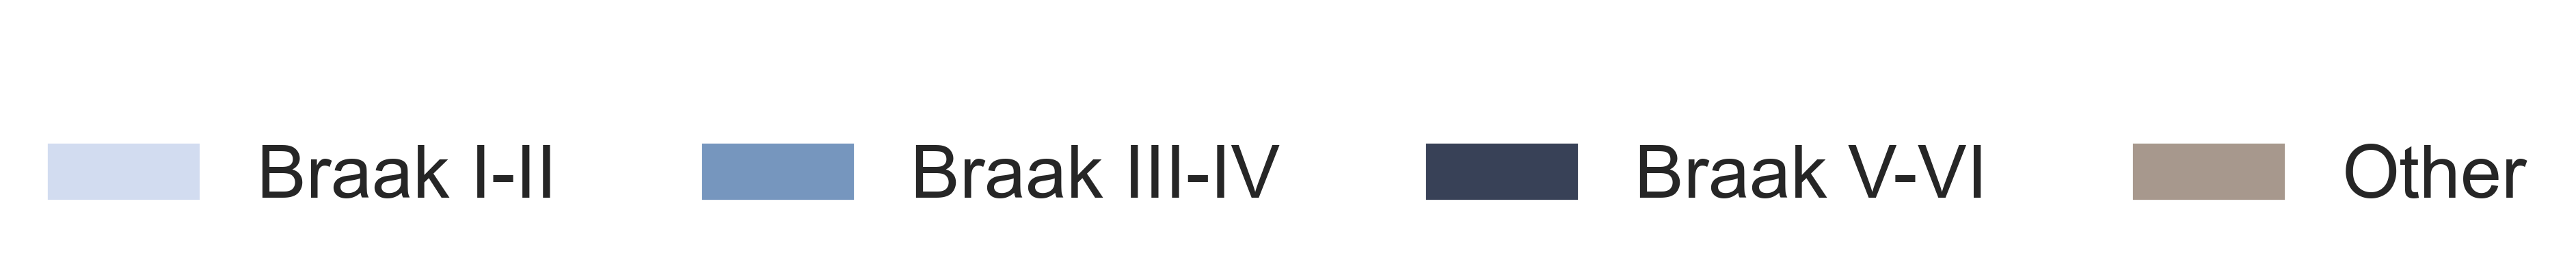

In [3]:
# sns.set_context('talk')
# fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)
# ax.axis('off')
# patches = [mpatches.Patch(color=roi_colors[roi], label=roi) for i, roi in enumerate(anatomical_rois_hemi2.keys())]
# labels = ['Braak I-II', 'Braak III-IV', 'Braak V-VI']
# ax.legend(handles=patches, labels=labels, ncol=3, loc='center', bbox_to_anchor=(0, 0), fontsize='x-large')
# if savefig:
#     plt.savefig(os.path.join(plots_dir, f'legend.pdf'), bbox_inches='tight', dpi=300)
# plt.show()

sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)
ax.axis('off')

# Create patches for existing ROIs
patches = [mpatches.Patch(color=roi_colors[roi], label=roi) for i, roi in enumerate(anatomical_rois_hemi2.keys())]
# Add patch for "Other"
patches.append(mpatches.Patch(color='#A7988DFF', label='Other'))  # Replace 'gray' with your desired color (e.g., '#808080')

# Add "Other" to labels
labels = ['Braak I-II', 'Braak III-IV', 'Braak V-VI', 'Other']

ax.legend(handles=patches, labels=labels, ncol=4, loc='center', bbox_to_anchor=(0, 0), fontsize='x-large')

if savefig:
    plt.savefig(os.path.join(connplot_dir, f'nbs_legend.pdf'), bbox_inches='tight', dpi=300)
plt.show()

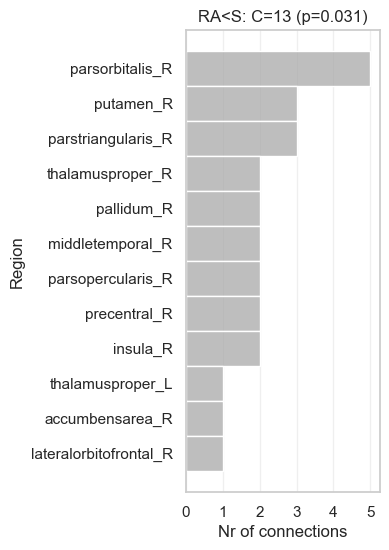

In [4]:
from matplotlib.ticker import MaxNLocator

df_adjmat = pd.DataFrame(adj_mats[:,:, 0], columns=node_labels, index=node_labels)

df_conn_count = df_adjmat.sum(axis=1).reset_index()
df_conn_count.columns = ['Region', 'Connections']
df_conn_count = df_conn_count[df_conn_count['Connections'] > 0]
df_conn_count = df_conn_count.sort_values(by='Connections', ascending=False)

# region_names_dict = {
#     'frontalpole_L': 'Left frontal pole',
#     'superiortemporal_L': 'Left superior temporal gyrus',
#     'thalamusproper_L': 'Left thalamus',
#     'frontalpole_R': 'Right frontal pole',
#     'lateraloccipital_L': 'Left lateral occipital cortex',
#     'parsorbitalis_L': 'Left pars orbitalis',
#     'parstriangularis_R': 'Right pars triangularis',
#     'superiorfrontal_R': 'Right superior frontal gyrus',
#     'supramarginal_R': 'Right supramarginal gyrus',
#     'cuneus_L': 'Left cuneus',
#     'lingual_L': 'Left lingual gyrus',
#     'superiorfrontal_L': 'Left superior frontal gyrus',
#     'superiorparietal_L': 'Left superior parietal lobule',
#     'pallidum_L': 'Left pallidum',
#     'putamen_R': 'Right putamen'
# }
df_conn_count_ = df_conn_count.copy()
# df_conn_count_['Region'] = df_conn_count_['Region'].replace(region_names_dict)

sns.set_context('notebook')
sns.set_style('whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)

plt.figure(figsize=(2.5, 6), dpi=100)
sns.histplot(data=df_conn_count_, y='Region', weights='Connections', discrete=True, color='darkgray')
plt.xlabel('Nr of connections')
plt.ylabel('Region')
plt.title(plot_title)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.grid(False)
if savefig:
    plt.savefig(os.path.join(connplot_dir, f'regions_histplot_{mat_fname[:-4]}.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# print('\n')
# for row in df_adjmat.index:
#     for col in df_adjmat.columns:
#         if df_adjmat.at[row, col] == 1:
#             print(f"{row} is connected to {col}")